## Simulating the Wealth Distribution: Part I

This notebook contains the code for simulating wealth dynamics.  Savings follows an ad hoc rule.

Author: John Stachurski

In [32]:
!date

Mon Oct  1 06:58:11 EDT 2018


In [1]:
from numba import jit, njit, vectorize
import numpy as np
from numpy import exp, log

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Model 1: Constant $r$

In [3]:
sigma = 1.5
mu = 1.5
r = 0.1

@vectorize
def s(w):
    if w < 1.0:
        return 0
    else:
        return 0.6 * w

@vectorize
def phi(t):
    """
    Density of lognormal LN(mu, sigma) when mu = -sigma^2 / 2 to maintain 
    mean of 1.
    """
    if t < 1e-10:
        return 0.0
    else:
        a = (2*np.pi)**(-0.5) * (1.0 / (t * sigma))
        b = exp(-(log(t) - mu)**2 / (sigma**2 / 2.0))
        return a * b

@njit
def sk(x, y):
    return phi(y - (1 + r) * s(x))

45 degree diagram

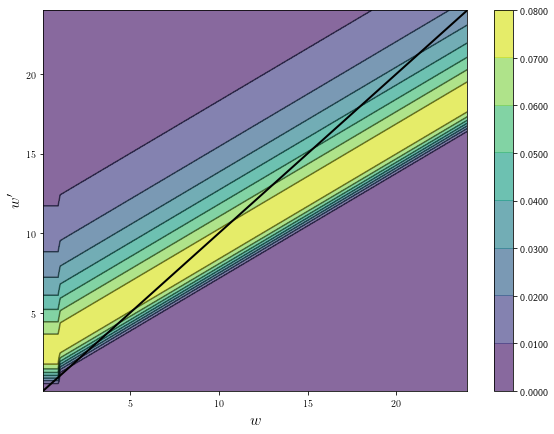

In [4]:
bottom, top = 0.1, 24
x_size, y_size = 200, 200
xgrid = np.linspace(bottom, top, x_size)
ygrid = np.linspace(bottom, top, x_size)
X, Y = np.meshgrid(xgrid, ygrid)

Z = np.empty((x_size, y_size))

for i in range(x_size):
    for j in range(y_size):
        Z[i, j] = sk(xgrid[i], ygrid[j])
Z = Z.T

fig, ax = plt.subplots(figsize=(9.5, 7))

cs1 = ax.contourf(X, Y, Z, alpha=0.65)
ctr1 = ax.contour(X, Y, Z, colors='black', alpha=0.5)

#plt.clabel(ctr1, inline=1, fontsize=10)
plt.colorbar(cs1, ax=ax, format="%.4f")

ax.plot(xgrid, xgrid, 'k-', lw=2.0, alpha=1)

#ax.grid(True)
ax.set_xlabel(r'$w$', fontsize=16)
ax.set_ylabel(r"$w'$", fontsize=16)

plt.show()

Time series

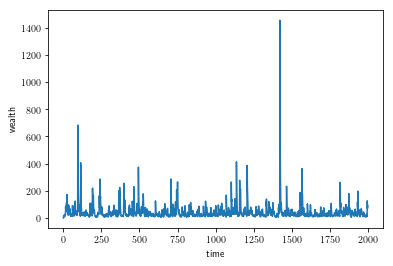

In [5]:
n = 2000
w = np.empty(n)
w[0] = 0.0

for t in range(n-1):
    w[t+1] = (1 + r) * s(w[t]) + exp(mu + sigma * np.random.randn())

fig, ax = plt.subplots()
ax.plot(w, label="$w_t$")
ax.set_xlabel("time")
ax.set_ylabel("wealth")
plt.show()

### Now with stochastic returns

We'll compute the integral in the stochastic kernel by Monte Carlo

In [6]:
M = 5000
r_sigma = 1.0
r_mu = - r_sigma**2 / 2  # maintain unit mean
R_draws = (1 + r) * exp(r_mu + r_sigma * np.random.randn(M))

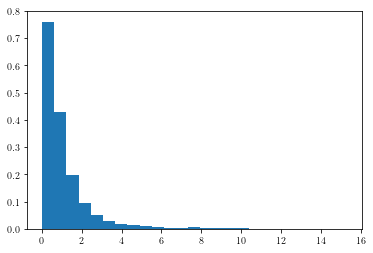

In [7]:
fig, ax = plt.subplots()
ax.hist(R_draws, bins=25, density=True)
plt.show()

In [8]:
R_draws.mean()

1.1015972372833205

In [9]:
@njit
def sk2(x, y):
    return np.mean(phi(y - R_draws * s(x)))

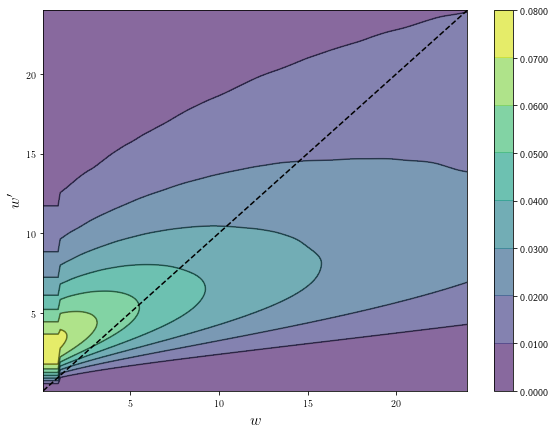

In [10]:
Z = np.empty((x_size, y_size))

for i in range(x_size):
    for j in range(y_size):
        Z[i, j] = sk2(xgrid[i], ygrid[j])
Z = Z.T

fig, ax = plt.subplots(figsize=(9.5, 7))

cs1 = ax.contourf(X, Y, Z, alpha=0.65)
ctr1 = ax.contour(X, Y, Z, colors='black', alpha=0.5)

#plt.clabel(ctr1, inline=1, fontsize=10)
plt.colorbar(cs1, ax=ax, format="%.4f")

ax.plot(xgrid, xgrid, 'k--', lw=1.5, alpha=1)

#ax.grid(True)
ax.set_xlabel(r'$w$', fontsize=16)
ax.set_ylabel(r"$w'$", fontsize=16)

plt.show()

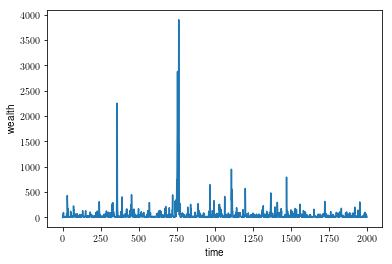

In [12]:
@njit
def gen_wealth_ts(n=2000):

    w = np.empty(n)
    w[0] = 0.0

    for t in range(n-1):
        R = (1 + r) * exp(r_mu + r_sigma * np.random.randn())
        w[t+1] = R * s(w[t]) + exp(mu + sigma * np.random.randn())
    return w

n = 2000
w = gen_wealth_ts(n)

fig, ax = plt.subplots()
ax.plot(w, label="$w_t$")
ax.set_xlabel("time")
ax.set_ylabel("wealth")
plt.show()

### Failure of Stability

In [11]:
α = 1.0
@njit
def q(x):
    return 5.0 / (1 + exp(- α * (x - 10.0)))

κ = 2.5
γ = 0.4
@njit
def g(x):
    return κ +  q(x) * x**γ


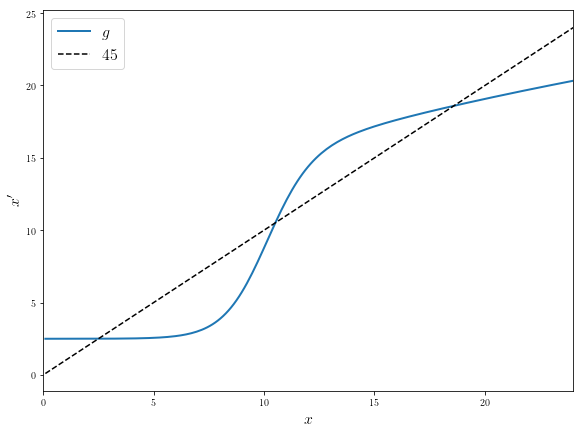

In [12]:

fig, ax = plt.subplots(figsize=(9.5, 7))

ax.plot(xgrid, [g(x) for x in xgrid], label="$g$", lw=2.0, alpha=1)

ax.plot(xgrid, xgrid, 'k--', label="$45$", lw=1.5, alpha=1)

#ax.grid(True)
ax.set_xlim((0, 24))
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r"$x'$", fontsize=16)
ax.legend(fontsize=16)

plt.show()

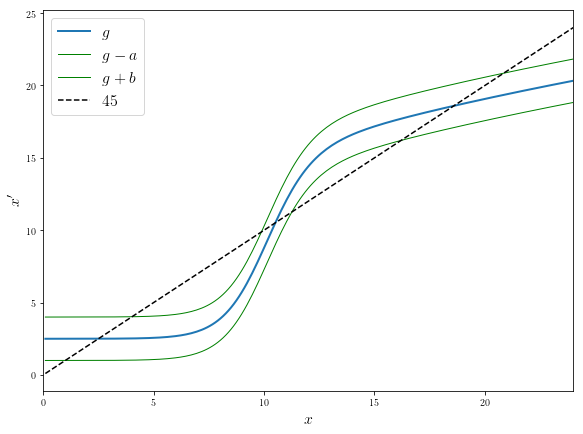

In [13]:

fig, ax = plt.subplots(figsize=(9.5, 7))

ax.plot(xgrid, [g(x) for x in xgrid], label="$g$", lw=2.0, alpha=1)
ax.plot(xgrid, [g(x) - 1.5 for x in xgrid], 
        'g-', label="$g - a$", lw=1.0, alpha=1)
ax.plot(xgrid, [g(x) + 1.5 for x in xgrid], 
        'g-', label="$g + b$", lw=1.0, alpha=1)

ax.plot(xgrid, xgrid, 'k--', label="$45$", lw=1.5, alpha=1)

#ax.grid(True)
ax.set_xlim((0, 24))
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r"$x'$", fontsize=16)
ax.legend(fontsize=16)

plt.show()

### Simulated distributions

In [14]:
@njit
def gen_marginal(w_init=1.0, num_reps=200, n=2000):

    w_sample = np.empty(num_reps)
    for i in range(num_reps):
        w = w_init 
        for t in range(n):
            R = (1 + r) * exp(r_mu + r_sigma * np.random.randn())
            w = R * s(w) + exp(mu + sigma * np.random.randn())
        w_sample[i] = w
    return w_sample

w_sample = gen_marginal()

In [15]:
def ecdf(x, sample):
    return np.mean(sample <= x)

#### tracking marginals 

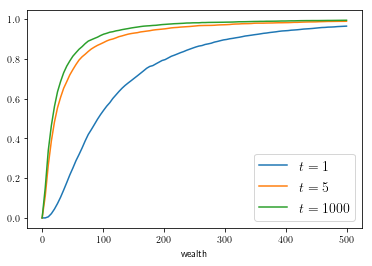

In [16]:
x_grid = np.linspace(0, 500, 100)

fig, ax = plt.subplots()

n_vals = [1, 5, 1000]

for n in n_vals:
    w_sample = gen_marginal(w_init=200, num_reps=5000, n=n)
    y_grid = [ecdf(x, w_sample) for x in x_grid]

    ax.plot(x_grid, y_grid, label=f"$t = {n}$")
    
ax.set_xlabel("wealth")
ax.legend(fontsize=14, loc="lower right")

plt.show()

#### DKW bands

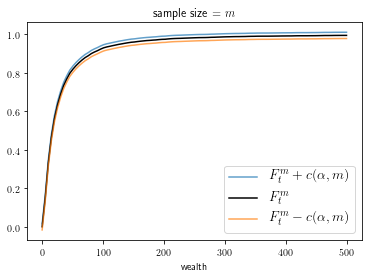

In [17]:
m = 10000
w_sample = gen_marginal(num_reps=m, w_init=200, n=100)

alpha = 0.01

eps = np.sqrt(np.log(2 / alpha) / (2 * m))

x_grid = np.linspace(0, 500, 100)
y_grid = [ecdf(x, w_sample) for x in x_grid]
ya = y_grid - eps
yb = y_grid + eps

fig, ax = plt.subplots()

ax.plot(x_grid, yb, alpha=0.7, label="$F_t^m + c(\\alpha, m)$")
ax.plot(x_grid, y_grid, 'k-', label="$F_t^m$")
ax.plot(x_grid, ya, alpha=0.7, label="$F_t^m - c(\\alpha, m)$")

ax.set_xlabel("wealth")
ax.legend(fontsize=14, loc="lower right")

ax.set_title(f"sample size = $m$")

plt.show()

#### the stationary distribution

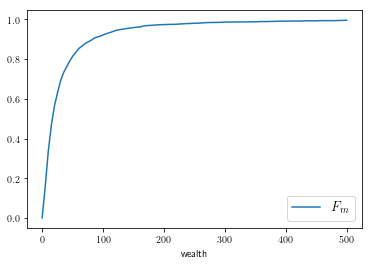

In [18]:
w_sample = gen_marginal(num_reps=2000)
x_grid = np.linspace(0, 500, 100)
y_grid = [ecdf(x, w_sample) for x in x_grid]

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$F_m$")
ax.set_xlabel("wealth")
ax.legend(fontsize=14, loc="lower right")

plt.show()

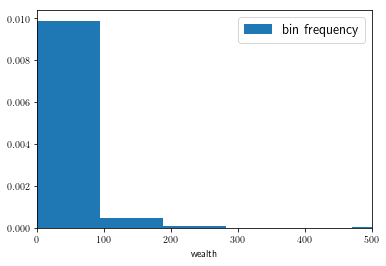

In [19]:
w_sample = gen_marginal(w_init=200, n=100, num_reps=5000)
fig, ax = plt.subplots()
ax.hist(gen_marginal(), label="bin frequency", density=True)

ax.set_xlim((0, 500))
ax.set_xlabel("wealth")
ax.legend(fontsize=14)

plt.show()

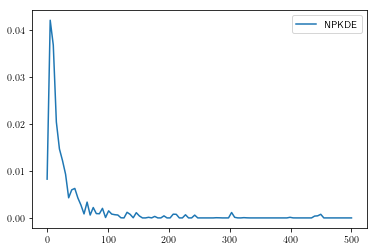

In [27]:

from sklearn.neighbors import KernelDensity
w_sample = gen_marginal(w_init=200, n=100, num_reps=500)
kde = KernelDensity(kernel='gaussian').fit(w_sample[:, None])
log_dens = kde.score_samples(x_grid[:, None])

fig, ax = plt.subplots()
ax.plot(x_grid, np.exp(log_dens), label="NPKDE")
ax.legend()

plt.show()


In [28]:
@njit
def lae(y, sample):
    pr = 0.0
    for x in sample:
        pr += sk2(y, x)
    return pr / len(sample)

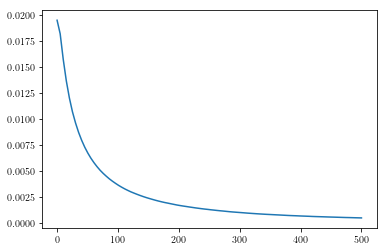

In [29]:
x_grid = np.linspace(0, 500, 100)
fig, ax = plt.subplots()

y_grid = [lae(x, w_sample) for x in x_grid]

ax.plot(x_grid, y_grid, label="$\ell_t^m")

plt.show()

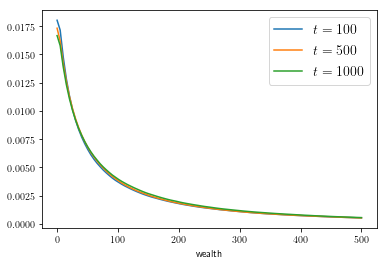

In [23]:
fig, ax = plt.subplots()

n_vals = [100, 500, 1000]

for n in n_vals:
    w_sample = gen_marginal(w_init=200, num_reps=500, n=n)
    y_grid = [lae(x, w_sample) for x in x_grid]

    ax.plot(x_grid, y_grid, label=f"$t = {n}$")
    
ax.set_xlabel("wealth")
ax.legend(fontsize=14, loc="upper right")

plt.show()


### Stationary Distributions



In [ ]:


w_sample = gen_wealth_ts(n=2000)

y_grid = [lae(x, w_sample) for x in x_grid]

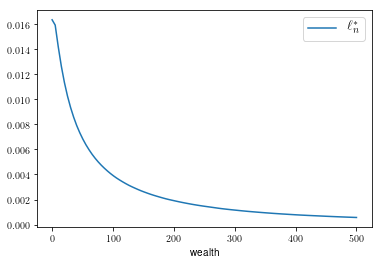

In [34]:
fig, ax = plt.subplots()

ax.plot(x_grid, y_grid, label="$\\ell_n^*$")

ax.set_xlabel("wealth")

ax.legend(fontsize=14, loc="upper right")


plt.show()